## DATA 620 

---
### Project 1 - Alt
### Mael Illien and Jeremy OBrien

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.
* For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes. You might use a t-test or another statistical measure to support your findings.


In [1]:
import csv
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from config import foursquare_config as fs_config

In [77]:
midtown_raw = pd.read_csv('venues_midtown_unique.csv')
downtown_raw = pd.read_csv('venues_downtown.csv')
westvil_raw = pd.read_csv('venues_westvil_unique.csv')

In [78]:
#downtown_raw.drop_duplicates()
#downtown_raw.reset_index()


In [79]:
# Cleanup datasets
midtown = midtown_raw.filter(items=['id', 'name','type'])
downtown = downtown_raw.drop_duplicates()
downtown = downtown.filter(items=['id', 'name','type'])
#downtown = downtown.reset_index()
westvil = westvil_raw.filter(items=['id', 'name','type'])

In [80]:
# Combine the 3 venues data frames into one
venues = midtown
venues = venues.append(westvil, ignore_index=True)
venues = venues.append(downtown, ignore_index=True)
venues = venues.drop_duplicates()
venues = venues.reset_index(drop=True)
print("Working with {} venues".format(len(venues)))
venues.head()

Working with 65 venues


,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout
2,49b7ed6df964a52030531fe3,Times Square,Plaza
3,41102700f964a520d60b1fe3,Macy's,Department Store
4,40b68100f964a5207d001fe3,Madison Square Park,Park


In [84]:
venues['type'].drop_duplicates()

0              Building
1        Scenic Lookout
2                 Plaza
3      Department Store
4                  Park
7           Candy Store
8      Theme Restaurant
10         Toys & Games
12           Basketball
13              Burgers
14              Gourmet
16      Farmer's Market
18             American
19            Bookstore
20          Coffee Shop
21             Fountain
26        Grocery Store
28    Outdoor Sculpture
29              Falafel
30              Dog Run
31         Indie Movies
32      Performing Arts
33               Market
34           Art Museum
35          Beer Garden
36          Electronics
37                Pizza
38            Cosmetics
40        Movie Theater
41            Wine Shop
42           Comic Shop
44        Memorial Site
47               Bridge
48                 Mall
50         New American
57           Food Court
60             Landmark
61        Historic Site
63               Island
Name: type, dtype: object

In [86]:
# Refine the categorical variable

venues['category'] = None

foods = ['Food Court','Theme Restaurant','Burgers','Gourmet',"Farmer's Market", 'Coffee Shop', 'Falafel', 
         'Beer Garden','Pizza','Food Court', 'Grocery Store', 'New American','American']
shops = ['Department Store', 'Candy Store', 'Toys & Games', 'Bookstore','Market','Electronics','Cosmetics',
         'Wine Shop','Comic Shop','Mall']
entertainment = ['Basketball','Indie Movies','Performing Arts','Art Museum','Movie Theater','Dog Run']
tourist = ['Building','Scenic Lookout','Plaza','Park','Fountain','Outdoor Sculpture',' Memorial Site',
           'Bridge','Landmark','Historic Site','Island','Memorial Site']

for i in range(len(venues)):
    venue_type = venues['type'][i]
    if venue_type in foods:
        venues['category'][i] = 'Food and Beverage'
    elif venue_type in shops:
        venues['category'][i] = 'Shopping'
    elif venue_type in entertainment:
        venues['category'][i] = 'Entertainment'
    elif venue_type in tourist:
        venues['category'][i] = 'Tourist Attraction'
    else:
        venues['category'][i] = 'Other'      

In [87]:
venues

,id,name,type,category
0,43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,Tourist Attraction
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction
3,41102700f964a520d60b1fe3,Macy's,Department Store,Shopping
4,40b68100f964a5207d001fe3,Madison Square Park,Park,Tourist Attraction
...,...,...,...,...
60,42893400f964a52054231fe3,Statue of Liberty,Landmark,Tourist Attraction
61,4ad0ec5df964a52023db20e3,Castle Clinton National Monument,Historic Site,Tourist Attraction
62,4a675deef964a52045c91fe3,Charging Bull,Landmark,Tourist Attraction
63,4c2ba1f857a9c9b67138f667,Liberty Island,Island,Tourist Attraction


In [88]:
#venues[venues['category'] == 'Other']

,id,name,type,category


In [ ]:
midtown['id'][0]

In [ ]:
midtown[midtown['id'] == '43695300f964a5208c291fe3']

In [40]:
# Fill these out to run but don't save to Github
CLIENT_ID = fs_config['id']
CLIENT_SECRET = fs_config['secret']

client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [89]:
def generate_links(locations):
    links = []

    for l in locations['id']:
        #print(l)
        next_locations = client.venues.nextvenues(l)['nextVenues']['items']
        
        for nl in next_locations:
            link = (l, nl['id'])
            #print(link)
            if not link in links:
                #if nl['id'] in locations['id']:
                    #print('adding link')
                links.append(link)          
    return links

def generate_network_from_locations(locations):
    #labels = dict(zip(list(venues['id']),list(venues['name'])))
    links = generate_links(locations)
    #print(links)
    
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
    return G

def generate_network_from_links(venues, links_file):
    # Read links from file which are stored a str representation of tuples
    links = []
    with open(links_file, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            as_tpl = eval(row[0])
            links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['type'] = venues['category'][i]
    # Trim nodes of degree 1 or less
    #small = [n for n in G.nodes if G.degree[n] <= 1]
    #G.remove_nodes_from(small)
        
    return G

def generate_network(venues, link_files):
    # Read links from file which are stored a str representation of tuples
    links = []
    for lf in link_files:
        with open(lf, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                as_tpl = eval(row[0])
                links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['type'] = venues['type'][i]
    # Trim nodes of degree 1 or less
    #small = [n for n in G.nodes if G.degree[n] <= 1]
    #G.remove_nodes_from(small)
        
    return G

In [90]:
link_files = ['links_midtown.csv','links_westvil.csv','links_downtown.csv']
g = generate_network(venues, link_files)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 107
Number of edges: 245
Average in degree:   2.2897
Average out degree:   2.2897


In [91]:
# Identify and drop nodes that have no info (too many are droppped)
no_name = [node for node in g.nodes if node not in list(venues['id'])]
g.remove_nodes_from(no_name)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 65
Number of edges: 199
Average in degree:   3.0615
Average out degree:   3.0615


## Compute metrics

In [92]:
def get_metrics(venues, graph):

    degree = nx.degree(graph)
    venues['degree'] = [degree[n] for n in venues['id']]

    pagerank = nx.pagerank(graph, alpha=.9)
    venues['pagerank'] = [pagerank[n] for n in venues['id']]

    betweenness = nx.betweenness_centrality(graph)
    venues['betweenness'] = [betweenness[n] for n in venues['id']]
    
    closeness = nx.closeness_centrality(graph)
    venues['closeness'] = [closeness[n] for n in venues['id']]
    
    return venues


In [93]:
venues

,id,name,type,category
0,43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,Tourist Attraction
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction
3,41102700f964a520d60b1fe3,Macy's,Department Store,Shopping
4,40b68100f964a5207d001fe3,Madison Square Park,Park,Tourist Attraction
...,...,...,...,...
60,42893400f964a52054231fe3,Statue of Liberty,Landmark,Tourist Attraction
61,4ad0ec5df964a52023db20e3,Castle Clinton National Monument,Historic Site,Tourist Attraction
62,4a675deef964a52045c91fe3,Charging Bull,Landmark,Tourist Attraction
63,4c2ba1f857a9c9b67138f667,Liberty Island,Island,Tourist Attraction


In [94]:
metrics = get_metrics(venues, g)

In [95]:
metrics.sort_values(by=['degree'], ascending=False).head()
#metrics.sort_values(by=['degree'], ascending=False).tail()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
43,4abe7f9ef964a520068e20e3,One World Trade Center,Building,Tourist Attraction,15,0.036169,0.076209,0.191406
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898


In [96]:
metrics.sort_values(by=['pagerank'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
47,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
9,49b79f54f964a5202c531fe3,Rockefeller Center,Plaza,Tourist Attraction,6,0.045355,0.000000,0.184230


In [97]:
metrics.sort_values(by=['betweenness'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
47,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
17,40abf500f964a52035f31ee3,Washington Square Park,Park,Tourist Attraction,11,0.014721,0.152679,0.211765
56,4a32c3f9f964a5208c9a1fe3,Manhattan Bridge,Bridge,Tourist Attraction,5,0.011933,0.148797,0.120888
0,43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction,12,0.024481,0.146280,0.198047


In [98]:
metrics.sort_values(by=['closeness'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
3,41102700f964a520d60b1fe3,Macy's,Department Store,Shopping,11,0.015229,0.078633,0.212193


## Visualization

In [99]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

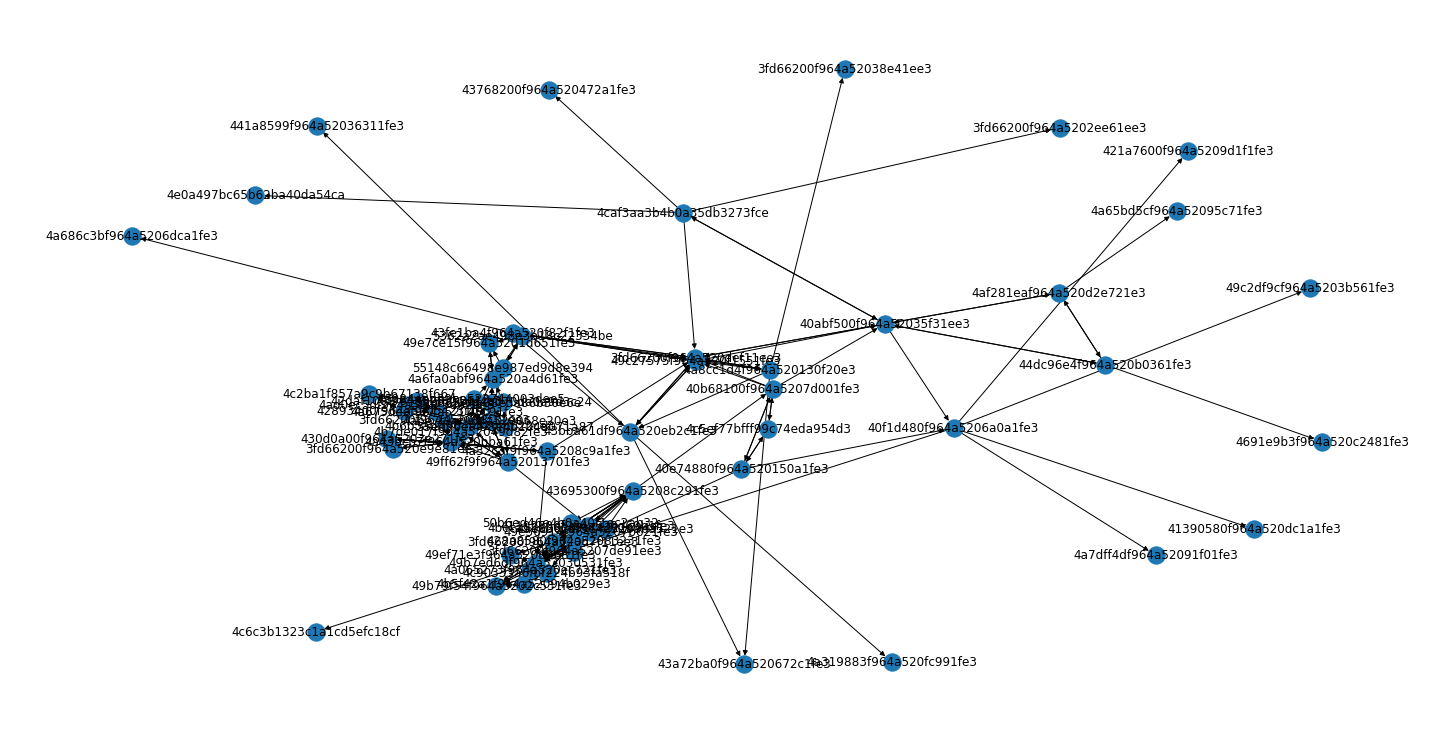

In [100]:
nx.draw(g, with_labels=True)

In [101]:
#small = [n for n in comb_g.nodes if comb_g.degree[n] <= 1]
#comb_g.remove_nodes_from(small)
#print(nx.info(comb_g))

In [102]:
labels = dict(zip(list(venues['id']),list(venues['name'])))
graph_pos = nx.spring_layout(g)

In [103]:
#[v['id'] for v in venues if v['category'] is 'foods'] 
fb_nodes = list(venues[venues['category'] == 'Food and Beverage']['id'])
sh_nodes = list(venues[venues['category'] == 'Shopping']['id'])
e_nodes = list(venues[venues['category'] == 'Entertainment']['id'])
t_nodes = list(venues[venues['category'] == 'Tourist Attractions']['id'])
o_nodes = list(venues[venues['category'] == 'Other']['id'])

{'43695300f964a5208c291fe3': Text(-0.180919495910865, 0.12704576485839197, 'Empire State Building'),
 '4bcca12bb6c49c7422169491': Text(-0.31997138507843176, 0.15151077862779974, '86th Floor Observation Deck'),
 '49b7ed6df964a52030531fe3': Text(-0.4402275107123577, 0.16433810290337447, 'Times Square'),
 '41102700f964a520d60b1fe3': Text(-0.31109168400677195, 0.1388850098249113, "Macy's"),
 '40b68100f964a5207d001fe3': Text(0.1928836233612078, 0.06810996073997996, 'Madison Square Park'),
 '3fd66200f964a520d7f11ee3': Text(-0.3764474024500776, 0.15097189116713727, 'Bryant Park'),
 '50b6ed46e4b0a40f1ec2ab32': Text(-0.3163770919500321, 0.16816263405265663, '102nd Floor Observatory'),
 '4a065273f964a520ec721fe3': Text(-0.46178949830338845, 0.1716294545648926, "M&M's World"),
 '428a8580f964a52083231fe3': Text(-0.3562500202541044, 0.16630118193234425, 'Hard Rock Cafe'),
 '49b79f54f964a5202c531fe3': Text(-0.529692629254552, 0.16566945187131601, 'Rockefeller Center'),
 '4c90333a6fbf224b93fa518f': T

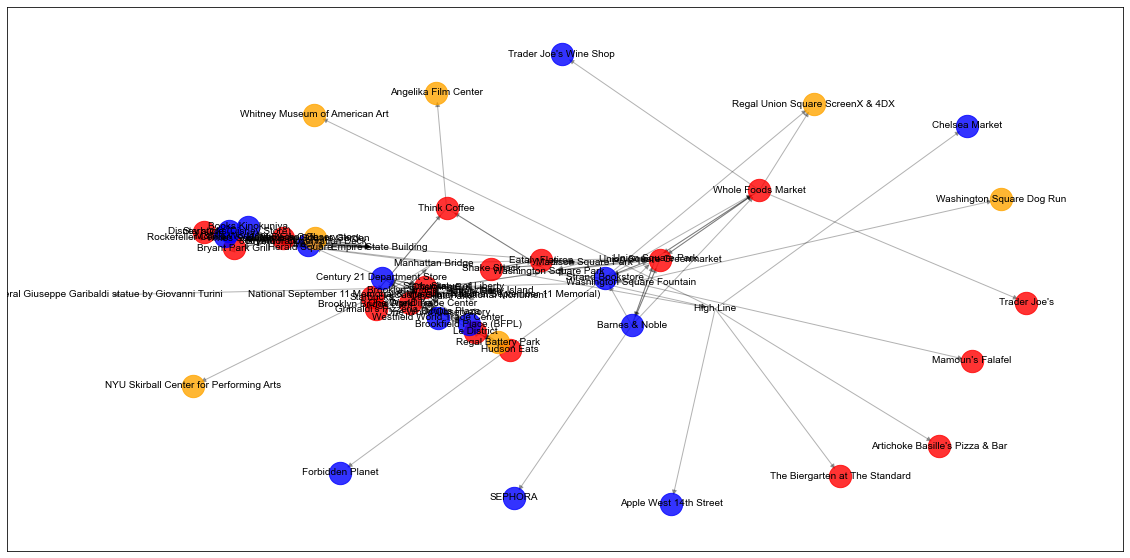

In [105]:
# Plot network

#fig = plt.figure(figsize(16,9), dpi=150)
pagerank = nx.pagerank(g, alpha=.9)
nodesize = [10000 * n for n in pagerank.values()]
#nx.draw_networkx_nodes(g, graph_pos, node_size=nodesize, alpha=.5, node_color='blue')

nx.draw_networkx_nodes(g, graph_pos, nodelist=fb_nodes, node_color='r', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(g, graph_pos, nodelist=sh_nodes, node_color='b', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(g, graph_pos, nodelist=e_nodes, node_color='orange', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(g, graph_pos, nodelist=t_nodes, node_color='green', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(g, graph_pos, nodelist=o_nodes, node_color='grey', node_size=500, alpha=0.8)

#nx.draw_networkx_nodes(g, pos, nodelist=[4,5,6,7], node_color='b', node_size=500, alpha=0.8)

nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='black')
nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')